In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
df = pd.read_csv("water_scarcity.csv")

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   5856 non-null   object 
 1   StationCode            5856 non-null   object 
 2   State                  5856 non-null   object 
 3   District               5856 non-null   object 
 4   Rainfall (mm)          5856 non-null   float64
 5   Groundwater Level (m)  5856 non-null   float64
 6   Temperature (°C)       5856 non-null   float64
 7   River Water Level (m)  5856 non-null   float64
 8   Scarcity               5856 non-null   int64  
dtypes: float64(4), int64(1), object(4)
memory usage: 411.9+ KB
None


In [5]:
df.head()

,Date,StationCode,State,District,Rainfall (mm),Groundwater Level (m),Temperature (°C),River Water Level (m),Scarcity
0,2024-01-01,ASS_BAR,Assam,Barpeta,0.0,20.0,41.3,14.30,0
1,2024-01-02,ASS_BAR,Assam,Barpeta,0.0,20.0,35.4,12.70,0
2,2024-01-03,ASS_BAR,Assam,Barpeta,17.9,20.0,22.9,11.48,0
3,2024-01-04,ASS_BAR,Assam,Barpeta,0.0,20.0,27.5,10.31,0
4,2024-01-05,ASS_BAR,Assam,Barpeta,0.0,20.0,30.6,5.56,0


In [6]:
# Select relevant features
features = ["Rainfall (mm)", "Groundwater Level (m)", "Temperature (°C)", "River Water Level (m)"]
target_col = "Scarcity"

In [7]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns  

# Fill NaN values in numeric columns with the median
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

In [8]:
# Encode categorical variables
label_encoders = {}
for col in ["State", "District"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [9]:
# Scale numerical features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [10]:
# Save encoders & scaler
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [11]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target_col], test_size=0.2, random_state=42)

In [12]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# Predictions & evaluation
y_pred = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1075
           1       1.00      1.00      1.00        97

    accuracy                           1.00      1172
   macro avg       1.00      1.00      1.00      1172
weighted avg       1.00      1.00      1.00      1172



In [14]:
# Save Random Forest model
with open("scarcity_classifier.pkl", "wb") as f:
    pickle.dump(rf_model, f)

In [15]:
np.unique(y_pred, return_counts=True)

(array([0, 1], dtype=int64), array([1075,   97], dtype=int64))

**LSTM MODEL**

In [20]:
# Ensure numeric columns are properly converted
numeric_features = ["Rainfall (mm)", "Groundwater Level (m)", "Temperature (°C)", "River Water Level (m)"]
for col in numeric_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing numeric data
df.dropna(subset=numeric_features, inplace=True)

# Aggregate only numeric columns
grouped_df = df.groupby(["State", "District", "Date"])[numeric_features + ["Scarcity"]].mean().reset_index()


In [21]:
# Function to create LSTM sequences
def create_sequences(data, n_steps=6):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data.iloc[i:i+n_steps][features + [target_col]].values)
        y.append(data.iloc[i+n_steps][target_col])
    return np.array(X), np.array(y)

Epoch 1/20


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5806 - loss: 0.6689
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9198 - loss: 0.3325
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8905 - loss: 0.2849
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9022 - loss: 0.2605
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8949 - loss: 0.2865
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9113 - loss: 0.2460
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9122 - loss: 0.2408
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9048 - loss: 0.2631
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8771 - loss: 0.3073
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9040 - loss: 0.2578
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8912 - loss: 0.2718
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8622 - loss: 0.3154


LSTM MAE for 0-2: 0.1395746433424979


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8405 - loss: 0.5925
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8965 - loss: 0.3090
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9342 - loss: 0.1995
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8867 - loss: 0.2731
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9156 - loss: 0.2272
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9276 - loss: 0.2156
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9152 - loss: 0.2274
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9404 - loss: 0.1882
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9097 - loss: 0.2307
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9135 - loss: 0.2189
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9288 - loss: 0.1958
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9188 - lo

LSTM MAE for 0-5: 0.18787864588015196
Epoch 1/20


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7947 - loss: 0.5946
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8715 - loss: 0.3237
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8718 - loss: 0.2969
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8858 - loss: 0.2626
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8957 - loss: 0.2476
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9045 - loss: 0.2489
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8954 - loss: 0.2551
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9112 - loss: 0.2262
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8915 - loss: 0.2546
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8588 - loss: 0.2950
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8879 - loss: 0.2517
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8926 - loss: 0.2343


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023C12D6B100> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


LSTM MAE for 0-6: 0.16988028998141036


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4697 - loss: 0.6860
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9268 - loss: 0.3350
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9307 - loss: 0.2102
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8911 - loss: 0.2715
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9353 - loss: 0.2065
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8921 - loss: 0.2604
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9224 - loss: 0.2202
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9197 - loss: 0.2098
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9036 - loss: 0.2469
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9202 - loss: 0.2204
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9207 - loss: 0.2137
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9015 - lo

LSTM MAE for 0-9: 0.16861847321639772


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4643 - loss: 0.7036  
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9011 - loss: 0.3821
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9338 - loss: 0.2083
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9058 - loss: 0.2628
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9247 - loss: 0.2170
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9077 - loss: 0.2444
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9093 - loss: 0.2542
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8968 - loss: 0.2558
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9157 - loss: 0.2232
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8902 - loss: 0.2580
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9038 - loss: 0.2473
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9078 - 

LSTM MAE for 0-11: 0.1993021654925136


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8591 - loss: 0.6078
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9355 - loss: 0.2824
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9383 - loss: 0.1793
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9439 - loss: 0.1758
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9352 - loss: 0.1750
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9377 - loss: 0.1804
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9163 - loss: 0.2216
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9525 - loss: 0.1383
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9292 - loss: 0.1804
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9342 - loss: 0.1669
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9390 - loss: 0.1541
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9352 - lo

LSTM MAE for 0-14: 0.1271623337967263
Epoch 1/20


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7275 - loss: 0.6357
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8746 - loss: 0.3520
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8886 - loss: 0.2832
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9006 - loss: 0.2649
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8754 - loss: 0.3134
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9106 - loss: 0.2421
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8500 - loss: 0.3391
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8622 - loss: 0.3260
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9160 - loss: 0.2392
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8737 - loss: 0.3070
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8552 - loss: 0.3284
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8968 - loss: 0.2677


LSTM MAE for 1-1: 0.152561730442058


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9301 - loss: 0.5592
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9128 - loss: 0.2997
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8969 - loss: 0.2689
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9059 - loss: 0.2539
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9166 - loss: 0.2403
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9302 - loss: 0.2005
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8988 - loss: 0.2533
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9199 - loss: 0.2190
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9303 - loss: 0.1996
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9153 - loss: 0.2340
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9064 - loss: 0.2284
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9284 - lo

LSTM MAE for 1-3: 0.12885373907233705


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4030 - loss: 0.7020   
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9354 - loss: 0.3442
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9182 - loss: 0.2358
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9334 - loss: 0.1809
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9293 - loss: 0.1904
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9579 - loss: 0.1485
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9383 - loss: 0.1995
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9114 - loss: 0.2226
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9299 - loss: 0.1845
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9169 - loss: 0.2166
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9217 - loss: 0.1976
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9210 -

LSTM MAE for 1-4: 0.15237464457802663


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8949 - loss: 0.6032
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9050 - loss: 0.3362
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9316 - loss: 0.1986
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9285 - loss: 0.2068
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9265 - loss: 0.2014
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9132 - loss: 0.2213
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9068 - loss: 0.2197
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9312 - loss: 0.1778
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9007 - loss: 0.2160
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9243 - loss: 0.1787
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8975 - loss: 0.2320
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9094 - lo

LSTM MAE for 1-8: 0.1666500163663033


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8292 - loss: 0.6084
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9262 - loss: 0.2740
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9555 - loss: 0.1489
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9293 - loss: 0.2162
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9244 - loss: 0.2008
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9404 - loss: 0.1777
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9265 - loss: 0.1940
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9484 - loss: 0.1596
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9274 - loss: 0.1923
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9474 - loss: 0.1576
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9213 - loss: 0.2101
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9471 - lo

LSTM MAE for 1-15: 0.151425403798464


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9181 - loss: 0.5678
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9046 - loss: 0.2964
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9085 - loss: 0.2659
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9283 - loss: 0.2243
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9072 - loss: 0.2437
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9085 - loss: 0.2524
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8961 - loss: 0.2636
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9354 - loss: 0.1986
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9317 - loss: 0.2041
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9000 - loss: 0.2586
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9123 - loss: 0.2392
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9314 - lo

LSTM MAE for 2-0: 0.19848642760653265


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8611 - loss: 0.6058
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8772 - loss: 0.3133
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9137 - loss: 0.2209
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9091 - loss: 0.2307
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8845 - loss: 0.2631
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9048 - loss: 0.2241
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8980 - loss: 0.2303
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8983 - loss: 0.2061
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9072 - loss: 0.2135
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9172 - loss: 0.1983
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9056 - loss: 0.2064
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9109 - lo

LSTM MAE for 2-7: 0.12375117888962195
Epoch 1/20


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8358 - loss: 0.6082
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8979 - loss: 0.3073
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9030 - loss: 0.2493
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9171 - loss: 0.2357
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9156 - loss: 0.2271
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8706 - loss: 0.2975
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9166 - loss: 0.2236
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8972 - loss: 0.2526
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8872 - loss: 0.2618
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8974 - loss: 0.2434
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8811 - loss: 0.2621
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8767 - loss: 0.2751


LSTM MAE for 2-10: 0.14688784824887913


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9262 - loss: 0.5396
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9302 - loss: 0.2218
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9594 - loss: 0.1507
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9583 - loss: 0.1458
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9668 - loss: 0.1315
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9609 - loss: 0.1429
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9554 - loss: 0.1464
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9534 - loss: 0.1558
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9609 - loss: 0.1409
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9381 - loss: 0.1881
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9637 - loss: 0.1194
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9485 - lo

LSTM MAE for 2-12: 0.17848981384678383


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8828 - loss: 0.5703
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9090 - loss: 0.2714
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9034 - loss: 0.2603
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9105 - loss: 0.2529
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8917 - loss: 0.2799
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9154 - loss: 0.2307
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9304 - loss: 0.2091
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9291 - loss: 0.2130
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9113 - loss: 0.2322
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9156 - loss: 0.2239
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8999 - loss: 0.2408
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9298 - lo

LSTM MAE for 2-13: 0.20616074362494088


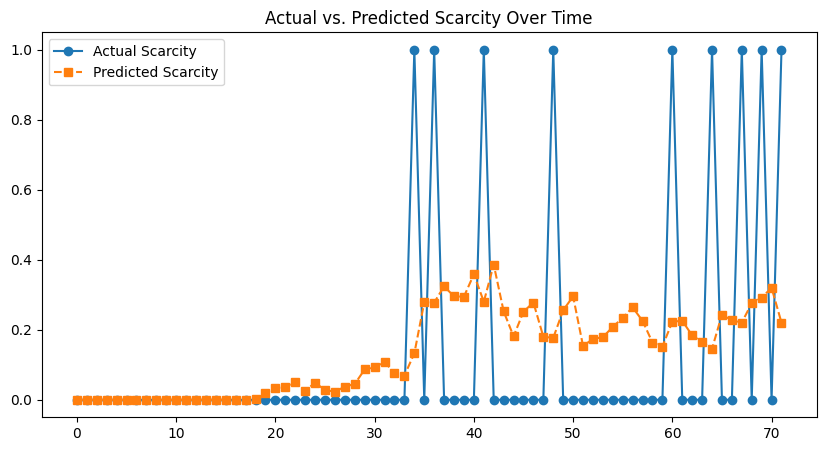

In [22]:
# Train LSTM models per state-district
lstm_models = {}
for (state, district), group in grouped_df.groupby(["State", "District"]):
    group.set_index("Date", inplace=True)
    
    if group.shape[0] < 12:  # Skip if not enough data
        continue
    
    X, y = create_sequences(group)
    if X.shape[0] < 10:  # Ensure enough samples
        continue

    # Split into train/test sets
    split = int(0.8 * len(X))
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

    # Define LSTM Model
    model = Sequential([
        LSTM(50, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    
    # Train model
    model.fit(X_train, y_train, epochs=20, batch_size=8, verbose=1)

    # Evaluate model
    y_pred_lstm = model.predict(X_test)
    print(f"LSTM MAE for {state}-{district}: {mean_absolute_error(y_test, y_pred_lstm)}")

    # Save LSTM model
    model.save(f"lstm_scarcity_{state}_{district}.h5")
    lstm_models[(state, district)] = model

# --- Graphs: Actual vs. Predicted ---
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual Scarcity", marker='o')
plt.plot(y_pred_lstm, label="Predicted Scarcity", linestyle="dashed", marker='s')
plt.legend()
plt.title("Actual vs. Predicted Scarcity Over Time")
plt.show()

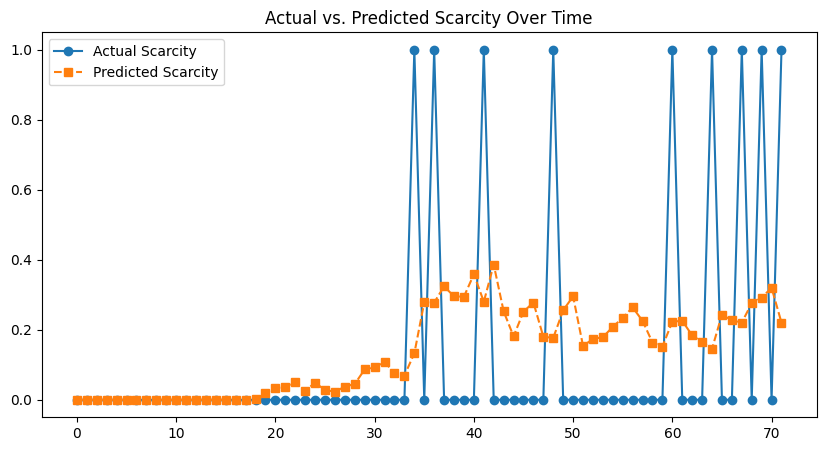

In [23]:
# --- Graphs: Actual vs. Predicted ---
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual Scarcity", marker='o')
plt.plot(y_pred_lstm, label="Predicted Scarcity", linestyle="dashed", marker='s')
plt.legend()
plt.title("Actual vs. Predicted Scarcity Over Time")
plt.show()